### **Exercise 5**

In [166]:
! pip install GPy
! pip install optunity
! pip install sobol
! pip install sobol_seq

In [167]:
import GPy
import optunity
import sobol
import numpy as np
from numpy import pi, cos
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy as sci

# **1)** GP optimization of a Toy Problem

1.)

In [181]:
def f_xy(x, y):
    f = x**2 - x + y**2 + y - cos(2 * pi * x - pi) - cos(2 * pi * y + pi) + 2.5
    return (f)

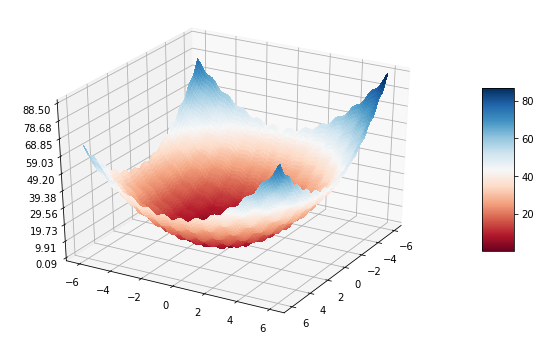

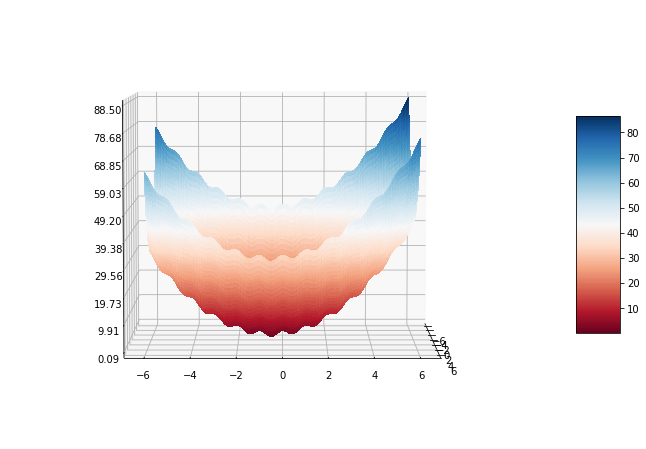

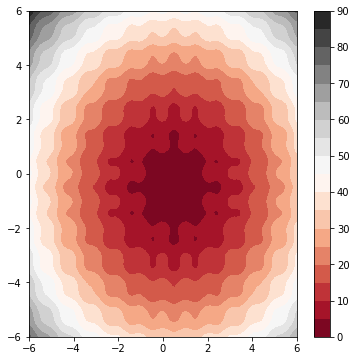

In [182]:
x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)
x, y = np.meshgrid(x, y)
f = f_xy(x, y)


fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.gca(projection='3d')
surf1 = ax1.plot_surface(x, y, f, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax1.view_init(30, 30)
fig1.colorbar(surf1, shrink=0.5, aspect=5)
fig1.show()


fig2 = plt.figure(figsize=(12,8))
ax2 = fig2.gca(projection='3d')
surf2 = ax2.plot_surface(x, y, f, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.view_init(5, 0)
fig2.colorbar(surf2, shrink=0.5, aspect=5)
fig2.show()


plt.figure(3, figsize=(6, 6))
plt.contourf(x, y, f, 20, cmap='RdGy')
plt.colorbar()
plt.show()


In [183]:
# Overview
x_uni = np.random.uniform(-6, 6, 60)
y_uni = np.random.uniform(-6, 6, 60)
f_uni = f_xy(x_uni, y_uni)
print(sci.stats.describe(f_uni))

DescribeResult(nobs=60, minmax=(1.3890135131586323, 74.47898280818887), mean=26.144859461172555, variance=255.30280095093792, skewness=0.7431999093500786, kurtosis=0.0859149334002618)


2.)

In [184]:
def utility(x, y):
    q = np.array([[x, y]])
    E_q = model.predict(q)[0]
    Var_q = model.predict(q)[1]
    index_min = np.argmin(model.predict(X_train)[0])
    E_best = f_xy(X_train[index_min][0], X_train[index_min][1])
    gamma = (E_best - E_q) / np.sqrt(Var_q)
    u = np.sqrt(Var_q) * (gamma * sci.stats.norm.pdf(gamma) + sci.stats.norm.cdf(gamma))
    return(u)

3.)

In [211]:
# initial set of 30 training points from  sobol sequence
number_of_samples = 30
parameterUpperLimits = np. array ([6 ,6])
parameterLowerLimits = np. array ([ -6 , -6])
x_train = np.zeros(number_of_samples)
y_train = np.zeros(number_of_samples)

for i in range (number_of_samples):
    x_train[i], y_train[i] = sobol.i4_sobol (2,i)[0] * ( parameterUpperLimits - parameterLowerLimits ) + parameterLowerLimits

4.)

In [212]:
X_train = np.stack((x_train, y_train), axis=1)
print(X_train.shape)

(30, 2)


In [213]:
# initial training set
f_train = f_xy(x_train, y_train)
f_train = f_train[:, np.newaxis]
print(f_train.shape)

(30, 1)


5.), 6.), 7.), 8.)

In [214]:
kernel = GPy.kern.RBF(2) + GPy.kern.White(2)

# true and predicted values for later plotting
f_true = []
f_pred = []

for i in range(30):

    model = GPy.models.GPRegression(X_train, f_train, kernel)
    model.optimize()

    # saving specific models for later
    if i == 0:
        model_initial = model
    if i == 29:
        model_final = model

    # finding point, which maximizes the expected improvement
    pars, details, _ = optunity.maximize(utility, x=[-6, 6], y=[-6, 6])

    # adding to training set
    x_train_new = np.zeros((1, 2))
    x_train_new[0, 0] = pars['x']
    x_train_new[0, 1] = pars['y']
    X_train = np.concatenate((X_train, x_train_new), axis=0)

    f_train_new = np.zeros((1, 1))
    f_train_new[0,0] = f_xy(pars['x'], pars['y'])
    f_train = np.concatenate((f_train, f_train_new), axis=0)

    f_true.append(f_train_new[0,0])
    f_pred.append(model.predict(x_train_new)[0][0])

f_true = np.array(f_true)
f_pred = np.array(f_pred)

 /usr/local/lib/python3.7/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


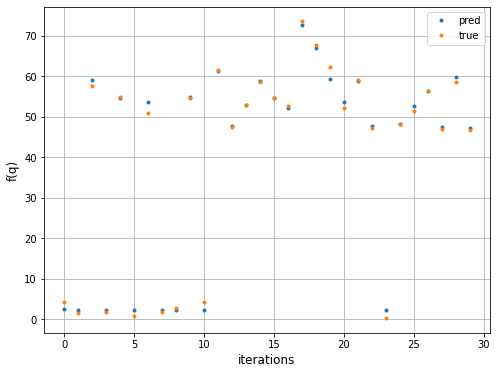

In [215]:
# truth and predictions at candidate points as function of iterations
plt.figure(figsize=(8,6))
plt.xlabel('iterations', fontsize=12)
plt.ylabel('f(q)', fontsize=12)
plt.plot(f_pred, '.', label='pred')
plt.plot(f_true, '.', label='true')
plt.legend()
plt.grid()
plt.show()

9.)

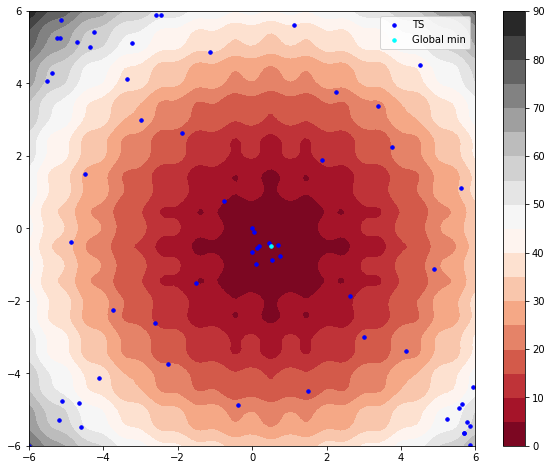

In [216]:
# visualize global minimum and TS
plt.figure(figsize=(10, 8))
plt.contourf(x, y, f, 20, cmap='RdGy')
plt.colorbar()
plt.scatter(X_train[:,0], X_train[:,1], 12, color='blue', label='TS')
plt.scatter(0.5, -0.5, 12, color='cyan', label='Global min')  
plt.legend()
plt.show()

10.)

11.)

In [217]:
# shaping data in order to feed to models
x_new = x.reshape(10000,1)
y_new = y.reshape(10000,1)
X_try = np.concatenate((x_new, y_new), axis=1)

# initial predictions
pred_init = model_initial.predict(X_try)[0]
ped_init = np.array(pred_init)
pred_init = pred_init.reshape((100,100))

# final predictions
pred_final = model_final.predict(X_try)[0]
pred_final = np.array(pred_final)
pred_final = pred_final.reshape((100,100))


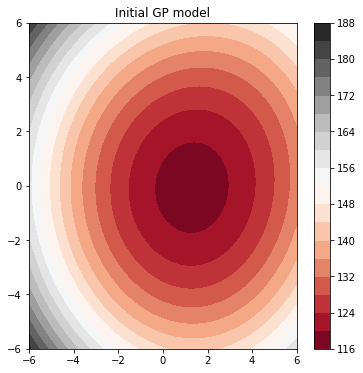

In [218]:
plt.figure(figsize=(6, 6))
plt.title('Initial GP model')
plt.contourf(x, y, pred_init, 20, cmap='RdGy')
plt.colorbar()
plt.show()

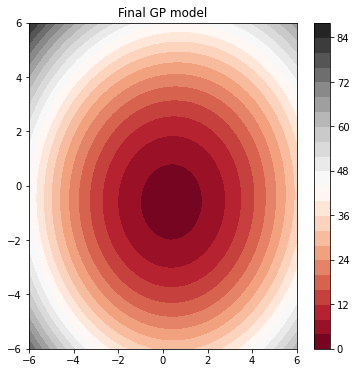

In [219]:
plt.figure(figsize=(6, 6))
plt.title('Final GP model')
plt.contourf(x, y, pred_final, 20, cmap='RdGy')
plt.colorbar()
plt.show()